# Multilayer Perceptron

In this notebook, we briefly introduce the multilayer perceptron model, then apply it on the CVDs dataset.

---

## Introduce 

A [multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) (MLP) is a class of feedforward artificial neural network (ANN). An MLP consists of at least three layers of nodes: an input layer, a hidden layer and an output layer. Except for the input nodes, each node is a neuron that uses a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training. Its multiple layers and non-linear activation distinguish MLP from a linear perceptron. It can distinguish data that is not linearly separable.

---

## Algorithm

A multilayer neural network is multilayer of perceptrons. It consists an input layer, several hidden layers, output layer, fully connected weights and non-linear activation function. The architecture of MLP is shown in the following image.

<img src="multilayerPerceptron.jpg" alt="Drawing" style="width: 450px;"/>

For our activation function, we will use the sigmoid function:

* Sigmoid Function
$$
\sigma(z) = \frac{1}{1+e^{-z}}.
$$

For our cost function, we will use the Mean Sqaure Error cost:
$$
C(W, b) = \frac{1}{2}\sum_{k=1}^{2}(\hat{y}^{(i)}_k - y^{(i)}_k)^2.
$$

### Feedforward Phase

For $\ell = 1, \dots, L$, each layer $\ell$ in our network will have two phases, the preactivation phase $$\mathbf{z}^{\ell} = W^{\ell}\mathbf{a}^{\ell-1} + \mathbf{b}^{\ell},$$ and postactivation phase $$\mathbf{a}^{\ell} = \sigma(\mathbf{z}^{\ell}).$$ The preactivation phase consists of a weighted linear combination of postactivation values in the previous layer. The postactivation values consists of passing the preactivation value through an activation function elementwise. Note $\mathbf{a}^0 = \mathbf{x}^{(i)}$, where $\mathbf{x}^{(i)}$ is the current input data into our network. 

### Backpropogation Phase with Stochastic Gradient Descent 
The backpropogation phase with stochastic gradient descetn is shown as below:

1. For each $i = 1, \dots, N$.
2. Feedforward $\mathbf{x}^{(i)}$ into the network. 
3. Compute $\delta^{L} = \nabla_aC\otimes \sigma'(\mathbf{z}^{L})$.
4. For $\ell = L-1, \dots, 1$, compute $\delta^{\ell} = \big ( (\mathbf{w}^{\ell + 1})^{T} \delta^{\ell + 1} \Big )\otimes \sigma'(\mathbf{z}^{\ell})$.
5. For $\ell = L, L-1, \dots, 1$, 

$$
w^{\ell} \leftarrow w^{\ell} - \alpha \delta^{\ell}(\mathbf{a}^{\ell-1})^{T}
$$

$$
b^{\ell} \leftarrow b^{\ell} - \alpha \delta^{\ell}
$$

---

## Coding

In [310]:
# Import the libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Set theme for plotting
sns.set_theme()

First, we define our sigmoid activation function, its derivative, and the mean squared error for a single instance of training data.

In [311]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def d_sigmoid(z):
    return sigmoid(z)*(1.0 - sigmoid(z))

def mse(a, y):
    return .5*sum((a[i] - y[i])**2 for i in range(len(y)))[0]

Next we write a custom function to initialize the weight matrices and bias column vectors for a dense neural network.

In [312]:
def initialize_weights(layers):
    # The following Python lists will contain numpy matrices
    # connected the layers in the neural network 
    W = [[0.0]]
    B = [[0.0]]
    for i in range(1, len(layers)):
        # The scalling factor is something I found in a research paper :)
        w_temp = np.random.randn(layers[i], layers[i-1])*np.sqrt(2/layers[i-1])
        b_temp = np.random.randn(layers[i], 1)*np.sqrt(2/layers[i-1])
    
        W.append(w_temp)
        B.append(b_temp)
    return W, B

Then we define the feedforward phase funciton and the overall MSE cost funciton.

In [313]:
def forward_pass(W, B, xi, predict_vector = False):
    Z = [[0.0]]
    A = [xi]
    L = len(W) - 1
    for i in range(1, L + 1):
        z = W[i] @ A[i-1] + B[i]
        Z.append(z)
        
        a = sigmoid(z)
        A.append(a)
        
    if predict_vector == False:
        return Z, A
    else:
        return A[-1]

def MSE(W, B, X, y):
    cost = 0.0
    m = 0
    for xi, yi in zip(X, y):
        xi = xi.reshape(-1,1)
        a = forward_pass(W, B, xi, predict_vector = True)
        cost += mse(a, yi)
        m+=1
    return cost/m

We are now ready to define a custom Python ```DenseNetwork``` class.

In [314]:
class DenseNetwork(object):
    def __init__(self, layers):
        self.layers = layers
        self.W, self.B = initialize_weights(layers = self.layers)

    def train(self, X_train, y_train, alpha = 0.046, epochs = 10):
        # Print the initial mean squared error
        self.errors_ = [MSE(self.W, self.B, X_train, y_train)]
        print(f"Starting Cost = {self.errors_[0]}")

        # Find your sample size
        sample_size = len(X_train)

        # Find the number of non-input layers.
        L = len(self.layers) - 1

        # For each epoch perform stochastic gradient descent. 
        for k in range(epochs):
            # Loop over each (xi, yi) training pair of data.
            for xi, yi in zip(X_train, y_train):
                # Use the forward pass function defined before
                # and find the preactivation and postactivation values.
                xi = xi.reshape(-1,1)
                Z, A = forward_pass(self.W, self.B, xi)

                # Store the errors in a dictionary for clear interpretation
                # of computation of these values.
                deltas = dict()

                # Compute the output error 
                output_error = (A[L] - yi)*d_sigmoid(Z[L])
                deltas[L] = output_error

                # Loop from L-1 to 1. Recall the right entry of the range function 
                # is non-inclusive. 
                for i in range(L-1, 0, -1):
                    # Compute the node errors at each hidden layer
                    deltas[i] = (self.W[i+1].T @ deltas[i+1])*d_sigmoid(Z[i])

                # Loop over each hidden layer and the output layer to perform gradient 
                # descent. 
                for i in range(1, L+1):
                    self.W[i] -= alpha*deltas[i] @ A[i-1].T
                    self.B[i] -= alpha*deltas[i]

            # Show the user the cost over all training examples
            self.errors_.append(MSE(self.W, self.B, X_train, y_train))   
            print(f"{k + 1}-Epoch Cost = {self.errors_[-1]}")
    

    def predict(self, xi):
        depth = len(self.layers)
        _, A = forward_pass(self.W, self.B, xi)
        return np.argmax(A[-1])

In [315]:
# Import the data
df = pd.read_csv("https://raw.githubusercontent.com/YulinLi98/Sample_Repo/main/heart.csv")

# Data Preprocessing by onehot encoding
df.Sex = df.Sex.replace({'M':1, 'F':0})
df.ExerciseAngina = df.ExerciseAngina.replace({'Y':1, 'N':0})

ChestPainType = pd.get_dummies(df.ChestPainType,drop_first=True)
RestingECG = pd.get_dummies(df.RestingECG,drop_first=True)
ST_Slope = pd.get_dummies(df.ST_Slope,drop_first=True)
df = pd.concat([df,ChestPainType, RestingECG, ST_Slope],axis=1)
df.drop(['ChestPainType', 'RestingECG', 'ST_Slope'],axis=1,inplace=True)

# Standardize the data
df.Age = preprocessing.scale(df.Age)
df.RestingBP = preprocessing.scale(df.RestingBP)
df.MaxHR = preprocessing.scale(df.MaxHR)
df.Cholesterol = preprocessing.scale(df.Cholesterol)
df.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ATA,NAP,TA,Normal,ST,Flat,Up
0,-1.433140,1,0.410909,0.825070,0,1.382928,0,0.0,0,1,0,0,1,0,0,1
1,-0.478484,0,1.491752,-0.171961,0,0.754157,0,1.0,1,0,1,0,1,0,1,0
2,-1.751359,1,-0.129513,0.770188,0,-1.525138,0,0.0,0,1,0,0,0,1,0,1
3,-0.584556,0,0.302825,0.139040,0,-1.132156,1,1.5,1,0,0,0,1,0,1,0
4,0.051881,1,0.951331,-0.034755,0,-0.581981,0,0.0,0,0,1,0,1,0,0,1


In [316]:
X = df.drop('HeartDisease',axis=1).to_numpy()
y = df.HeartDisease

# Create a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [317]:
# One hot encode the training labels
onehot_y_train = []

for y in zip(y_train):
    temp_vec = np.zeros((2, 1))
    temp_vec[y][0] = 1.0
    onehot_y_train.append(temp_vec)

In [318]:
# Initialize a network with 15 input nodes, two hidden layers with 4 nodes each 
# and a output layer with 2 nodes. 
np.random.seed(1)
net = DenseNetwork(layers = [15,4,4,2])

# Check the mean squared error before training 
print(f"MSE(net.W, net.B, X_train, onehot_y_train) = {MSE(net.W, net.B, X_train, onehot_y_train)} \n")

# Make a random prediction before training
np.random.seed(2)
i = np.random.randint(0, len(X_test))
prediction = net.predict(X_test[i].reshape(-1,1))
print(f"predicted label is: {prediction}")
print(f"actual label is: {np.argmax(y_test[i])}")

MSE(net.W, net.B, X_train, onehot_y_train) = 0.24396244621056098 

predicted label is: 1
actual label is: 0


In [319]:
# Train your network with stochastic gradient descent!
net.train(X_train, onehot_y_train, alpha = 0.046, epochs= 10)

Starting Cost = 0.24396244621056098
1-Epoch Cost = 0.23380841838583244
2-Epoch Cost = 0.21647577939685753
3-Epoch Cost = 0.19118891667104237
4-Epoch Cost = 0.16598326079669304
5-Epoch Cost = 0.14729894401810853
6-Epoch Cost = 0.13486646188711676
7-Epoch Cost = 0.1265387920487215
8-Epoch Cost = 0.12074310452941296
9-Epoch Cost = 0.11656461381501672
10-Epoch Cost = 0.1134847044891879


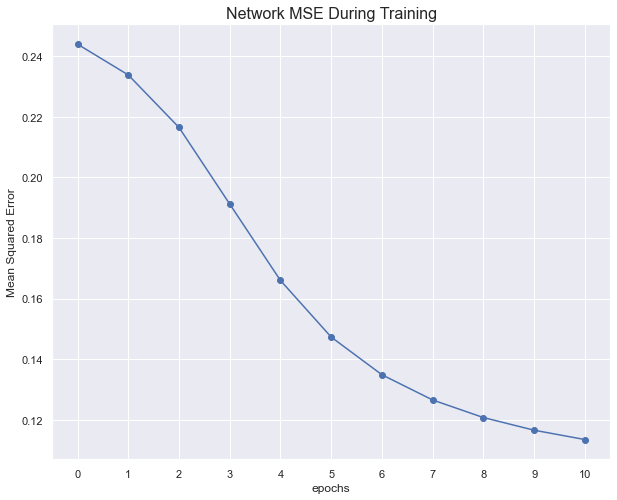

In [320]:
# Visualize the mean squared error over the training process 
plt.figure(figsize = (10, 8))
epochs = range(len(net.errors_))
plt.plot(epochs, net.errors_, marker = "o")
plt.xticks(epochs)
plt.xlabel("epochs")
plt.ylabel("Mean Squared Error")
plt.title("Network MSE During Training", fontsize = 16)
plt.show()

cf_matrix = [[ 97  15]
 [ 24 140]] 



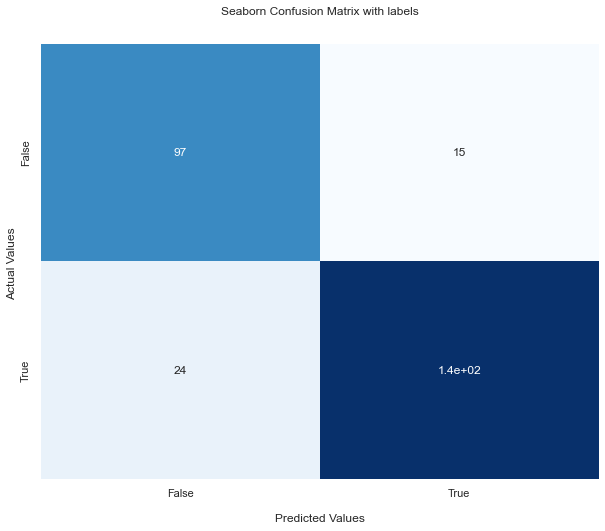

In [321]:
# Make predictions on testing data
y_pred = []
for xi in X_test:
    y_pred.append(net.predict(xi.reshape(-1,1)))

# Calculate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix 
print(f"cf_matrix = {cf_matrix} \n")

# View the confusion matrix using the seaborn package
plt.figure(figsize = (10, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', cbar=False)

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

In [322]:
#Check performance of our model with classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       112
           1       0.90      0.85      0.88       164

    accuracy                           0.86       276
   macro avg       0.85      0.86      0.86       276
weighted avg       0.86      0.86      0.86       276



The MLP model's accuracy is 0.86, which is greater than the single neuron perceptron model and less than the logistic regression model.

---

## Using TensorFlow package

In [323]:
import tensorflow as tf   # import tensorflow package

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(7, activation='sigmoid'),
  tf.keras.layers.Dense(2)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [324]:
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
21/21 [==============================] - 0s 1ms/step - loss: 1.2302 - accuracy: 0.4642
Epoch 2/50
21/21 [==============================] - 0s 1ms/step - loss: 1.1194 - accuracy: 0.4642
Epoch 3/50
21/21 [==============================] - 0s 2ms/step - loss: 1.0249 - accuracy: 0.4642
Epoch 4/50
21/21 [==============================] - 0s 2ms/step - loss: 0.9479 - accuracy: 0.4642
Epoch 5/50
21/21 [==============================] - 0s 1ms/step - loss: 0.8827 - accuracy: 0.4642
Epoch 6/50
21/21 [==============================] - 0s 2ms/step - loss: 0.8308 - accuracy: 0.4642
Epoch 7/50
21/21 [==============================] - 0s 1ms/step - loss: 0.7861 - accuracy: 0.4642
Epoch 8/50
21/21 [==============================] - 0s 1ms/step - loss: 0.7502 - accuracy: 0.4642
Epoch 9/50
21/21 [==============================] - 0s 1ms/step - loss: 0.7180 - accuracy: 0.4657
Epoch 10/50
21/21 [==============================] - 0s 1ms/step - loss: 0.6920 - accuracy: 0.4798
Epoch 11/50
21/21 [

In [325]:
model.evaluate(X_test,  y_test, verbose=2)

9/9 - 0s - loss: 0.3768 - accuracy: 0.8623 - 157ms/epoch - 17ms/step


[0.3768077790737152, 0.8623188138008118]

The accuracy by using TensorFlow package is also about 0.86.

---

## Conclusion

From the result above, we can see that the multilayer perceptron model performs well on the CVDs dataset. Compared with the single neuron perceptron model, the multilayer perceptron model has higher accuracy. The main reason is that the multilayer perceptron model can deal with non-linearly separable data.